In [1]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
import random

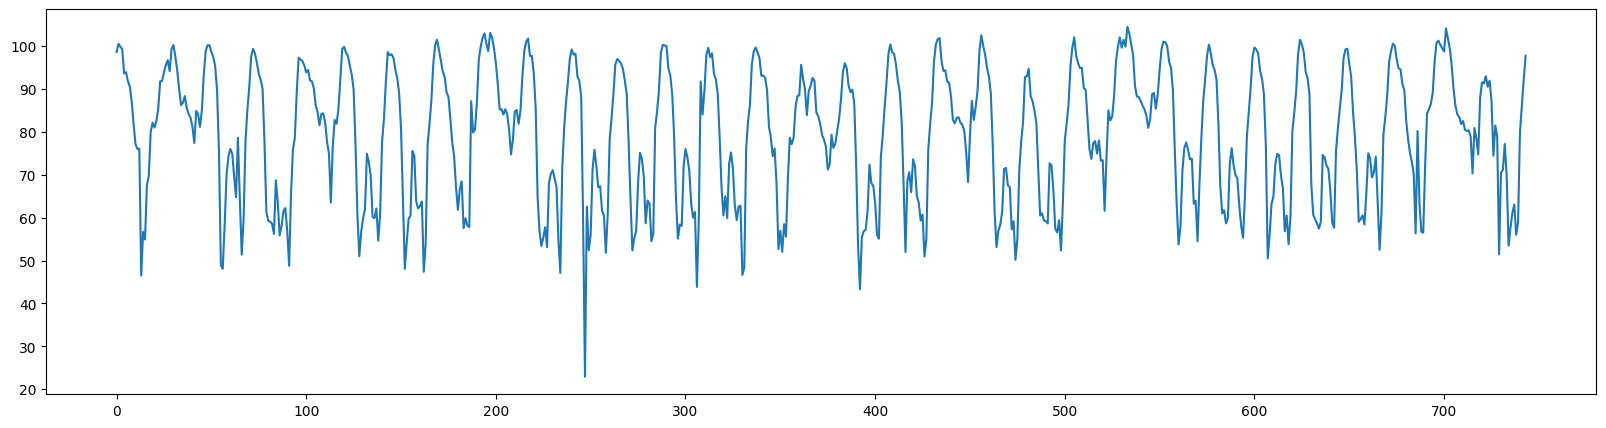

In [2]:
data = pd.read_csv("./datasets/서인천IC-부평IC 평균속도.csv", encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(range(len(data)), data["평균속도"])


In [3]:
print(len(data))
print(range(0,len(data)))

744
range(0, 744)


In [4]:
data['평균속도']

0       98.63
1      100.53
2       99.86
3       99.34
4       93.64
        ...  
739     58.86
740     79.86
741     86.01
742     92.28
743     97.76
Name: 평균속도, Length: 744, dtype: float64

In [5]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["평균속도"] = min_max_scaler.fit_transform(data["평균속도"].to_numpy().reshape(-1,1))

In [6]:
train = data[:-24*7]
train = train["평균속도"].to_numpy()

test = data[-24*7:]
test = test["평균속도"].to_numpy()

In [7]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

c:\Users\김기후\KimGihu\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [9]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)

        return output, self.hidden

In [10]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [11]:
a = [[1,2],[3,4]]

In [12]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [18]:
train.shape

(576,)

In [13]:
iw = 24*14
ow = 24*7

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

In [ ]:
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

In [ ]:
learning_rate=0.01
epoch = 3000
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

## 학습하기 이전

In [ ]:
predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

In [ ]:
plt.plot(predict)
plt.plot(real)

## 학습된 이후

In [ ]:
from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

## 평가하기

In [ ]:
predict = model.predict(torch.tensor(train[-24*7*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["평균속도"].to_numpy()

predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range(400,744), real[400:], label="real")
plt.plot(range(744-24*7,744), predict[-24*7:], label="predict")

plt.title("Test Set")
plt.legend()
plt.show()

In [ ]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPEval(predict[-24*7:],real[-24*7:])


## 결론

Encoder-Decoder LSTM을 사용해서 시계열 예측을 진행해본 결과 MAPE 8.04의 나쁘지 않은 성능을 확인할 수 있었다.

따라서 데이터의 주기를 따로 입력하지 않고도 좋은 성능을 얻어낼 수 있었기 때문에 주기를 알 수 없는 데이터에서 사용하면 좋을 것 같다.

훈련시간을 더 줄이기 위해서는 모델의 하이퍼파라미터를 튜닝하면 좋을 것 같다.